In [ ]:
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install segmentation_models

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout,LeakyReLU
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
import os
from glob import glob
from pathlib import Path
import shutil
from random import sample, choice
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip -uq "/content/gdrive/My Drive/CamVid.zip" -d "/CamVid"

In [ ]:
print(os.listdir("/CamVid/CamVid"))

['train_labels', 'test_labels', 'test', 'train', 'class_dict.csv', 'val', 'val_labels']


In [ ]:
dataset_path = Path("/CamVid/CamVid/")
list(dataset_path.iterdir())

[PosixPath('/CamVid/CamVid/train_labels'),
 PosixPath('/CamVid/CamVid/test_labels'),
 PosixPath('/CamVid/CamVid/test'),
 PosixPath('/CamVid/CamVid/train'),
 PosixPath('/CamVid/CamVid/class_dict.csv'),
 PosixPath('/CamVid/CamVid/val'),
 PosixPath('/CamVid/CamVid/val_labels')]

In [ ]:
def tree(directory):
    print(f'+ {directory}')
    for path in sorted(directory.rglob('*')):
        depth = len(path.relative_to(directory).parts)
        spacer = '    ' * depth
        print(f'{spacer}+ {path.name}')       
#tree(dataset_path)

In [ ]:
train_imgs = list((dataset_path / "train").glob("*.png"))
train_labels = list((dataset_path / "train_labels").glob("*.png"))
val_imgs = list((dataset_path / "val").glob("*.png"))
val_labels = list((dataset_path / "val_labels").glob("*.png"))
test_imgs = list((dataset_path / "test").glob("*.png"))
test_labels = list((dataset_path / "test_labels").glob("*.png"))

(len(train_imgs),len(train_labels)), (len(val_imgs),len(val_labels)) , (len(test_imgs),len(test_labels))

img_size = 512

In [ ]:
assert len(train_imgs) == len(train_labels), "No of Train images and label mismatch"
assert len(val_imgs) == len(val_labels), "No of Train images and label mismatch"
assert len(test_imgs) == len(test_labels), "No of Train images and label mismatch"

sorted(train_imgs), sorted(train_labels), sorted(val_imgs), sorted(val_labels), sorted(test_imgs), sorted(test_labels);

In [ ]:
for im in train_imgs:
    assert dataset_path / "train_labels" / (im.stem +"_L.png") in train_labels , "{im} not there in label folder"
for im in val_imgs:
    assert dataset_path / "val_labels" / (im.stem +"_L.png") in val_labels , "{im} not there in label folder"
for im in test_imgs:
    assert dataset_path / "test_labels" / (im.stem +"_L.png") in test_labels , "{im} not there in label folder"

In [ ]:
def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , dataset / label / (im.stem +"_L.png")))
    
    return pairs

In [ ]:
train_pair = make_pair(train_imgs, "train_labels", dataset_path)
val_pair = make_pair(val_imgs, "val_labels", dataset_path)
test_pair = make_pair(test_imgs, "test_labels", dataset_path)

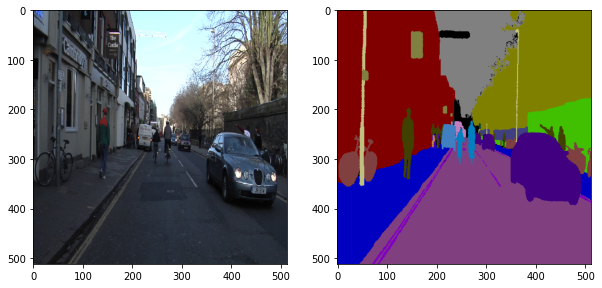

In [ ]:
temp = choice(train_pair)
img = img_to_array(load_img(temp[0], target_size=(img_size,img_size)))
mask = img_to_array(load_img(temp[1], target_size = (img_size,img_size)))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

In [ ]:
class_map_df = pd.read_csv(dataset_path / "class_dict.csv")

In [ ]:
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))
    
len(class_map)

32

In [ ]:
def assert_map_range(mask,class_map):
    mask = mask.astype("uint8")
    for j in range(img_size):
        for k in range(img_size):
            assert mask[j][k] in class_map , tuple(mask[j][k])

In [ ]:
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    
    return label

In [ ]:
lab = form_2D_label(mask,class_map)
np.unique(lab,return_counts=True)

(array([ 2,  4,  5,  6,  7,  8,  9, 10, 12, 14, 16, 17, 19, 21, 22, 24, 26,
        27, 30, 31], dtype=uint8),
 array([ 1567, 57028, 16483,   193,   103,  2969,  1325,  2016,  1726,
         6134,  3868, 68889, 25108, 22492,  1322,    82, 38973,   428,
         2498,  8940]))

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair, class_map, batch_size=16, dim=(512,512,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = to_categorical(label , num_classes = 32)
            batch_labels.append(label)

        return np.array(batch_imgs) ,np.array(batch_labels)


In [ ]:
train_generator = DataGenerator(train_pair+test_pair,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

150

In [ ]:
dX,y = train_generator.__getitem__(1)
y.shape

(4, 512, 512, 32)

In [ ]:
val_generator = DataGenerator(val_pair, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

25

In [ ]:
def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


input_img = Input(shape=(512, 512, 3),name='image_input')
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c6 = Conv2D(512, (3, 3), activation='relu', padding='same') (p5)
c6 = Conv2D(512, (3, 3), activation='relu', padding='same') (c6)
p6 = MaxPooling2D(pool_size=(2, 2)) (c6)

c7 = Conv2D(1024, (3, 3), activation='relu', padding='same') (p6)
c7 = Conv2D(1024, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample_conv(512, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c6])
c8 = Conv2D(512, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(512, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample_conv(256, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c5])
c9 = Conv2D(256, (3, 3), activation='relu', padding='same') (u9)
c9= Conv2D(256, (3, 3), activation='relu', padding='same') (c9)


u10 = upsample_conv(128, (3, 3), strides=(2, 2), padding='same') (c9)
u10 = concatenate([u10, c4])
c10 = Conv2D(128, (3, 3), activation='relu', padding='same') (u10)
c10 = Conv2D(128, (3, 3), activation='relu', padding='same') (c10)

u11 = upsample_conv(64, (2, 2), strides=(2, 2), padding='same') (c10)
u11 = concatenate([u11, c3])
c11 = Conv2D(64, (3, 3), activation='relu', padding='same') (u11)
c11 = Conv2D(64, (3, 3), activation='relu', padding='same') (c11)

u12 = upsample_conv(32, (2, 2), strides=(2, 2), padding='same') (c11)
u12 = concatenate([u12, c2])
c12 = Conv2D(32, (3, 3), activation='relu', padding='same') (u12)
c12 = Conv2D(32, (3, 3), activation='relu', padding='same') (c12)

u13 = upsample_conv(16, (2, 2), strides=(2, 2), padding='same') (c12)
u13 = concatenate([u13, c1], axis=3)
c13 = Conv2D(16, (3, 3), activation='relu', padding='same') (u13)
c13 = Conv2D(16, (3, 3), activation='relu', padding='same') (c13)

d = Conv2D(32, (1, 1), activation='softmax') (c13)


In [ ]:
iou = sm.metrics.IOUScore(threshold=0.5)

In [ ]:
seg_model = Model(inputs=[input_img], outputs=[d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         image_input[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 16) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
seg_model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy',iou])

In [ ]:
mc = ModelCheckpoint(mode='max', filepath='/content/gdrive/My Drive/Weights/Extended_Unet_Relu.h5', monitor='val_accuracy',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_accuracy', patience=10, verbose=1)
tb = TensorBoard(log_dir="logs/", histogram_freq=0, write_graph=True, write_images=False)
rl = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1,patience=10,verbose=1,mode="max",min_lr=0.0001)
cv = CSVLogger("logs/log.csv" , append=True , separator=',')

In [ ]:
results = seg_model.fit(train_generator , steps_per_epoch=train_steps ,epochs=150,
                              validation_data=val_generator,validation_steps=val_steps,callbacks=[mc,es,tb,rl,cv])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 150 steps, validate for 25 steps
Epoch 1/150
149/150 [============================>.] - ETA: 1s - loss: 2.7255 - accuracy: 0.2179 - iou_score: 0.2989
Epoch 00001: val_accuracy improved from -inf to 0.43841, saving model to /content/gdrive/My Drive/Weights/Extended_Unet_LRelu.h5
150/150 [==============================] - 202s 1s/step - loss: 2.7203 - accuracy: 0.2188 - iou_score: 0.2991 - val_loss: 1.8283 - val_accuracy: 0.4384 - val_iou_score: 0.2838
Epoch 2/150
149/150 [============================>.] - ETA: 1s - loss: 1.6730 - accuracy: 0.4995 - iou_score: 0.3292
Epoch 00002: val_accuracy improved from 0.43841 to 0.57923, saving model to /content/gdrive/My Drive/Weights/Extended_Unet_LRelu.h5
150/150 [==============================] - 197s 1s/step - loss: 1.6705 - accuracy: 0.5005 - iou_score: 0.3292 - val_loss: 1.4221 - val_accuracy: 0.5792 - val_iou_score: 0.3112
Epoch 3/150
149/150 [============================>.] - ETA: 

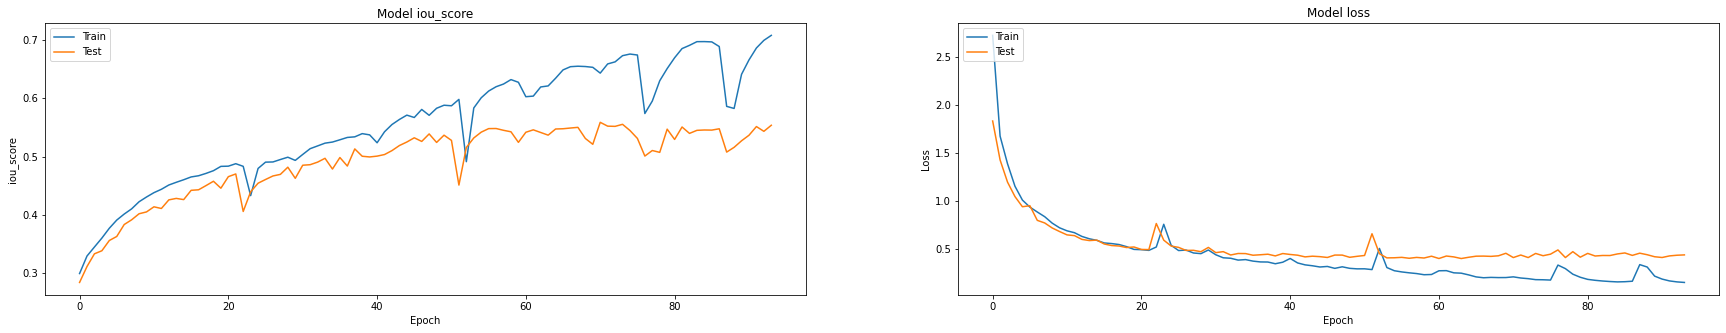

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(results.history['iou_score'])
plt.plot(results.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
img_mask = choice(val_pair)
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

In [ ]:
def make_prediction(model,img_path,shape):
    img= img_to_array(load_img(img_path , target_size= shape))/255.
    img = np.expand_dims(img,axis=0)
    labels = model.predict(img)
    labels = np.argmax(labels[0],axis=2)
    return labels

In [ ]:
pred_label = make_prediction(seg_model, img_mask[0], (img_size,img_size,3))
pred_label.shape

(512, 512)

In [ ]:
def form_colormap(prediction,mapping):
    h,w = prediction.shape
    color_label = np.zeros((h,w,3),dtype=np.uint8)    
    color_label = mapping[prediction]
    color_label = color_label.astype(np.uint8)
    return color_label

In [ ]:
pred_colored = form_colormap(pred_label,np.array(class_map))

Text(0.5, 1.0, 'predicted labels')

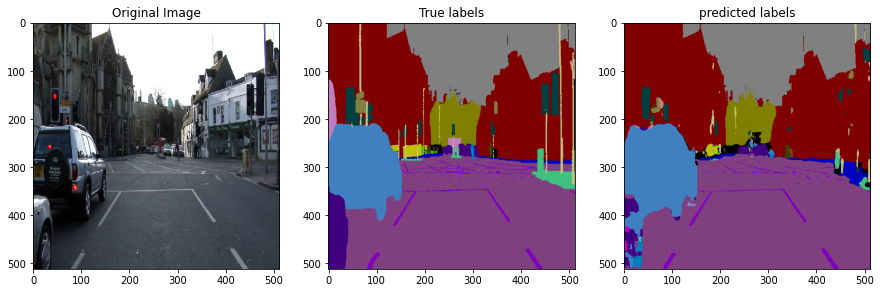

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')